<a href="https://colab.research.google.com/github/Ddmgboticks/MatchMaker/blob/main/Image_Identificatoin_muzzle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.image as mpimg

import pandas as pd
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import glob


# New section

In [36]:
import os
directory = '/content/sample_data/dataset/muzzle'
print(directory)
print(os.path.exists(directory))
#/content/sample_data
if os.path.exists(directory):
  print("dir found")
  all_images = glob.glob(directory+'/*/*.jpg')
  all_images[0]
len(all_images)


/content/sample_data/dataset/muzzle
True
dir found


50

  0%|          | 0/5 [00:00<?, ?it/s]

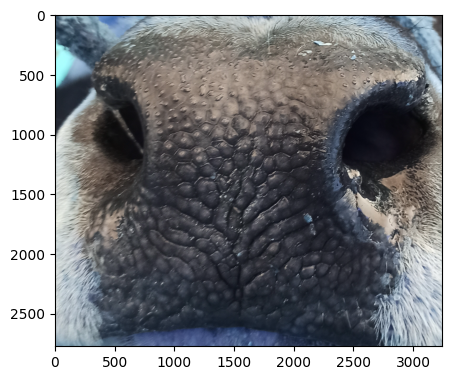

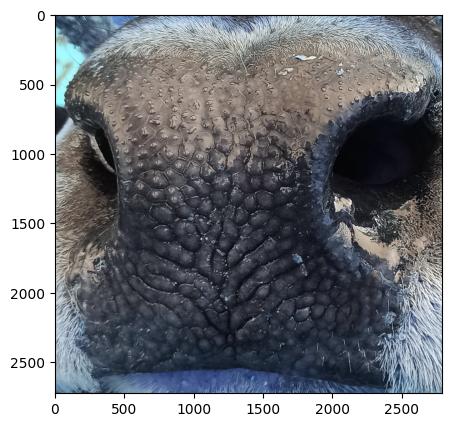

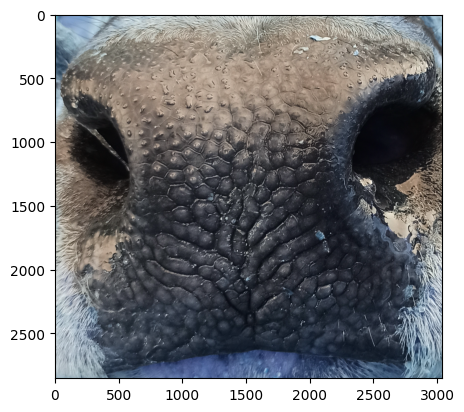

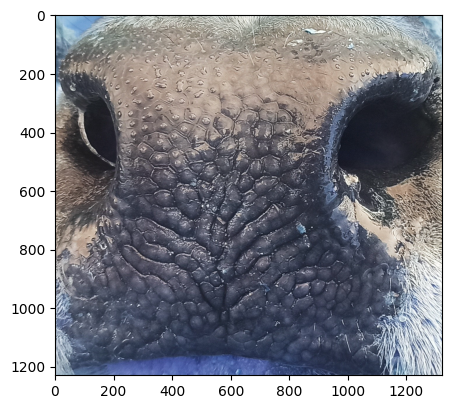

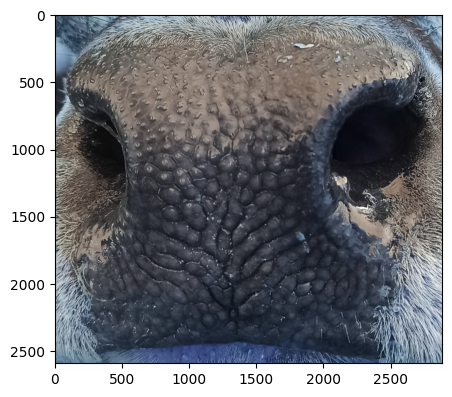

In [37]:
for f in tqdm(all_images[10:15]):
    img = cv2.imread(f)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()

In [38]:
# cattle id, image id, img path
df = pd.DataFrame(all_images,columns=['img_path'])

for i in tqdm(all_images):
    path = i
    chunk = path.split('/')[-1]
    chunk = chunk.split('.')[0]
    img_id = chunk.split('_')[-1]
    cattle_id = chunk.split('_')[-2]

    df.loc[df['img_path']==path,'img_id']=img_id
    df.loc[df['img_path']==path,'cattle_id']=cattle_id
df.info()

  0%|          | 0/50 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   50 non-null     object
 1   img_id     50 non-null     object
 2   cattle_id  50 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [39]:
# analyze each column
for col in df.columns:
    print(df[col].value_counts())
#     print('----------\n')
df.columns

/content/sample_data/dataset/muzzle/231-M74/IMG_20230811_143515.jpg    1
/content/sample_data/dataset/muzzle/223-M31/IMG_20230807_144759.jpg    1
/content/sample_data/dataset/muzzle/145-H2/IMG_20230327_143551.jpg     1
/content/sample_data/dataset/muzzle/145-H2/IMG_20230327_143554.jpg     1
/content/sample_data/dataset/muzzle/145-H2/IMG_20230327_143553.jpg     1
/content/sample_data/dataset/muzzle/223-M31/IMG_20230807_144758.jpg    1
/content/sample_data/dataset/muzzle/223-M31/IMG_20230807_144803.jpg    1
/content/sample_data/dataset/muzzle/223-M31/IMG_20230807_144712.jpg    1
/content/sample_data/dataset/muzzle/223-M31/IMG_20230807_144806.jpg    1
/content/sample_data/dataset/muzzle/223-M31/IMG_20230807_144805.jpg    1
/content/sample_data/dataset/muzzle/223-M31/IMG_20230807_144735.jpg    1
/content/sample_data/dataset/muzzle/223-M31/IMG_20230807_144801.jpg    1
/content/sample_data/dataset/muzzle/223-M31/IMG_20230807_144710.jpg    1
/content/sample_data/dataset/muzzle/231-M74/IMG_202

Index(['img_path', 'img_id', 'cattle_id'], dtype='object')

In [40]:
from sklearn.preprocessing import LabelEncoder


# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder to the data
encoder.fit(df['cattle_id'])

# Transform the data using the encoder
df['encoded_cattle_id'] = encoder.transform(df['cattle_id'])


In [41]:
df.columns

Index(['img_path', 'img_id', 'cattle_id', 'encoded_cattle_id'], dtype='object')

In [42]:
train_df = pd.DataFrame(columns= df.columns)
test_df = pd.DataFrame(columns= df.columns)

for cid in df['cattle_id'].unique():
    row = df.loc[df['cattle_id']==cid]
    total = row.shape[0]
    perc_80 = int(total*0.8)
    perc_20 = total - perc_80
    train_df = pd.concat([train_df,row[:perc_80+1]])
    test_df = pd.concat([test_df,row[perc_80+1:]])

In [15]:
train_df.columns

Index(['img_path', 'img_id', 'cattle_id', 'encoded_cattle_id'], dtype='object')

In [43]:
train_classes = len(train_df['cattle_id'].unique())
test_classes = len(test_df['cattle_id'].unique())

print(f'Num of unique classes in train dataset are {train_classes}\nNum of unique classes in test dataset are {test_classes}')

Num of unique classes in train dataset are 4
Num of unique classes in test dataset are 4


In [44]:
target_size = 64
train_df['encoded_cattle_id'] = train_df['encoded_cattle_id'].astype(str)
test_df['encoded_cattle_id'] = test_df['encoded_cattle_id'].astype(str)
df['encoded_cattle_id'] = df['encoded_cattle_id'].astype(str)

In [45]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rotation_range=90,
                                                               validation_split=0.20)

In [46]:
train_gen = train_datagen.flow_from_dataframe(train_df,
                                              x_col='img_path',
                                              y_col='encoded_cattle_id',
                                              target_size=(target_size,target_size),
                                              class_mode='categorical',
                                              subset='training')
# as we augment data, its essential to pass labels also

Found 36 validated image filenames belonging to 4 classes.


In [47]:
val_gen = train_datagen.flow_from_dataframe(train_df,
                                          x_col='img_path',
                                          y_col='encoded_cattle_id',
                                          target_size=(target_size,target_size),
                                          class_mode='categorical',
                                          subset='validation')

Found 8 validated image filenames belonging to 4 classes.


In [21]:
test_gen = train_datagen.flow_from_dataframe(test_df,
                                              x_col='img_path',
                                              y_col='encoded_cattle_id',
                                              target_size=(target_size,target_size),
                                              class_mode='categorical',
                                              subset='training')

Found 4 validated image filenames belonging to 2 classes.


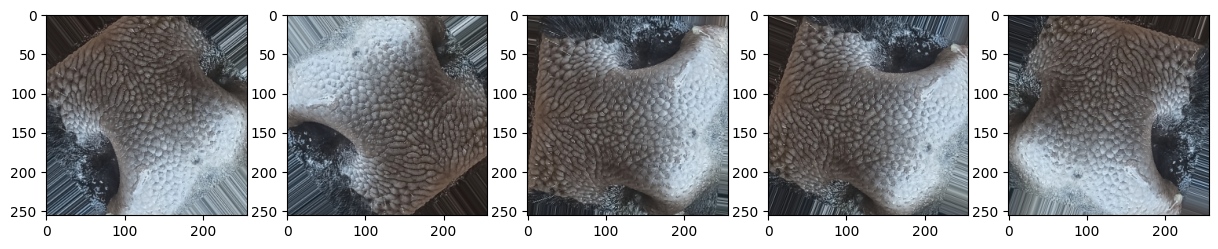

In [48]:
img_path = '/content/sample_data/dataset/muzzle/231-M74/IMG_20230811_143501.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))

# Convert image to numpy array
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Add a batch dimension to the array
img_array = np.expand_dims(img_array, axis=0)

# Generate augmented images using the flow() method
aug_iter = train_datagen.flow(img_array, batch_size=1)

# Visualize the augmented images
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    aug_img = next(aug_iter)[0]
    ax[i].imshow(aug_img)
plt.show()

In [50]:
# def UNet(inputs):
#     # First convolution block
#     x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
#     d1_con = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
#     d1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d1_con)

#     # Second convolution block
#     d2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d1)
#     d2_con = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
#     d2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d2_con)

#     # Third convolution block
#     d3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
#     d3_con = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d3)
#     d3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d3_con)

#     # Fourth convolution block
#     d4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d3)
#     d4_con = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d4)
#     d4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d4_con)

#     # Bottleneck layer
#     b = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d4)
#     b = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(b)

#     # First upsampling block
#     u1 = tf.keras.layers.Conv2DTranspose(512, 3, strides =(2,2),padding='same')(b)
#     u1 = tf.keras.layers.Concatenate(axis=3)([u1, d4_con])
#     u1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u1)
#     u1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u1)

#     # Second upsampling block
#     u2 = tf.keras.layers.Conv2DTranspose(256, 3, strides =(2,2),padding='same')(u1)
#     u2 = tf.keras.layers.Concatenate(axis=3)([u2, d3_con])
#     u2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u2)
#     u2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u2)



#     # Third upsampling block
#     u3 = tf.keras.layers.Conv2DTranspose(128, 3, strides =(2,2),padding='same')(u2)
#     u3 = tf.keras.layers.Concatenate(axis=3)([u3, d2_con])
#     u3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u3)
#     u3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u3)

#     # Fourth upsampling block
#     u4 = tf.keras.layers.Conv2DTranspose(64, 3, strides =(2,2),padding='same')(u3)
#     u4 = tf.keras.layers.Concatenate(axis=3)([u4, d1_con])
#     u4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u4)
#     u4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u4)

#     # Flatten and output
#     flat = tf.keras.layers.Flatten()(u4)
#     out = tf.keras.layers.Dense(units=269, activation='sigmoid')(flat)
#     model = tf.keras.Model(inputs=[inputs], outputs=[out])
#     return model

In [61]:
def UNet(inputs, num_classes=4):
    # First convolution block
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    d1_con = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    d1 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d1_con)

    # Second convolution block
    d2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d1)
    d2_con = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    d2 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d2_con)

    # Third convolution block
    d3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d2)
    d3_con = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d3)
    d3 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d3_con)

    # Fourth convolution block
    d4 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d3)
    d4_con = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d4)
    d4 = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(d4_con)

    # Bottleneck layer
    b = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(d4)
    b = tf.keras.layers.Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(b)

    # First upsampling block
    u1 = tf.keras.layers.Conv2DTranspose(512, 3, strides=(2, 2), padding='same')(b)
    u1 = tf.keras.layers.Concatenate(axis=3)([u1, d4_con])
    u1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u1)
    u1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u1)

    # Second upsampling block
    u2 = tf.keras.layers.Conv2DTranspose(256, 3, strides=(2, 2), padding='same')(u1)
    u2 = tf.keras.layers.Concatenate(axis=3)([u2, d3_con])
    u2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u2)
    u2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u2)

    # Third upsampling block
    u3 = tf.keras.layers.Conv2DTranspose(128, 3, strides=(2, 2), padding='same')(u2)
    u3 = tf.keras.layers.Concatenate(axis=3)([u3, d2_con])
    u3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u3)
    u3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u3)

    # Fourth upsampling block
    u4 = tf.keras.layers.Conv2DTranspose(64, 3, strides=(2, 2), padding='same')(u3)
    u4 = tf.keras.layers.Concatenate(axis=3)([u4, d1_con])
    u4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u4)
    u4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u4)

    # Flatten and output
    flat = tf.keras.layers.Flatten()(u4)
    out = tf.keras.layers.Dense(units=num_classes, activation='softmax')(flat)
    model = tf.keras.Model(inputs=[inputs], outputs=[out])
    return model

In [56]:
# auc = tf.keras.metrics.AUC(multi_label=True,thresholds=[0,1])
# aucpr = tf.keras.metrics.AUC(curve='PR',multi_label=True,thresholds=[0,1])
# inputs = tf.keras.layers.Input(shape=(target_size,target_size,3))
# unet = UNet(inputs)
# unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc, aucpr])
# unet.summary()


AttributeError: module 'tensorflow.keras' has no attribute 'compile'

In [79]:
auc = tf.keras.metrics.AUC(multi_label=True, thresholds=[0, 1])
aucpr = tf.keras.metrics.AUC(curve='PR', multi_label=True, thresholds=[0, 1])
inputs = tf.keras.layers.Input(shape=(target_size, target_size, 3))
unet = UNet(inputs)  # assuming 4 classes
unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auc, aucpr])

# To train the model, you can use the fit method
#unet.fit(train_gen, epochs=1, validation_data=val_gen)

# To print the model summary
unet.summary()



Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_180 (Conv2D)         (None, 64, 64, 64)           1792      ['input_11[0][0]']            
                                                                                                  
 conv2d_181 (Conv2D)         (None, 64, 64, 64)           36928     ['conv2d_180[0][0]']          
                                                                                                  
 max_pooling2d_40 (MaxPooli  (None, 32, 32, 64)           0         ['conv2d_181[0][0]']          
 ng2D)                                                                                      

In [52]:
unet

In [82]:
unet.fit(train_gen, epochs=10, validation_data=val_gen)

Epoch 1/10
2/2 [==============================] - 23s 6s/step - loss: 25.3003 - auc_20: 0.4429 - auc_21: 0.2474 - val_loss: 30.2103 - val_auc_20: 0.0000e+00 - val_auc_21: 0.2500
Epoch 2/10
2/2 [==============================] - 20s 17s/step - loss: 4.7209 - auc_20: 0.5000 - auc_21: 0.2500 - val_loss: 9.6525 - val_auc_20: 0.0000e+00 - val_auc_21: 0.2500
Epoch 3/10
2/2 [==============================] - 21s 16s/step - loss: 1.8684 - auc_20: 0.5000 - auc_21: 0.2500 - val_loss: 10.1579 - val_auc_20: 0.0000e+00 - val_auc_21: 0.2500
Epoch 4/10
2/2 [==============================] - 20s 3s/step - loss: 1.3697 - auc_20: 0.5000 - auc_21: 0.2500 - val_loss: 9.1698 - val_auc_20: 0.0000e+00 - val_auc_21: 0.2500
Epoch 5/10
2/2 [==============================] - 22s 3s/step - loss: 1.5559 - auc_20: 0.5000 - auc_21: 0.2500 - val_loss: 3.7369 - val_auc_20: 0.0000e+00 - val_auc_21: 0.2500
Epoch 6/10
2/2 [==============================] - 20s 17s/step - loss: 1.3780 - auc_20: 0.5000 - auc_21: 0.2500 - v

In [81]:
unet.evaluate(train_gen)

2/2 [==============================] - 7s 512ms/step - loss: 27.8946 - auc_20: 0.4607 - auc_21: 0.2478


[27.894575119018555, 0.46071428060531616, 0.2478388100862503]

In [92]:
evaluation_result=unet.evaluate(val_gen)
print("Accuracy:", evaluation_result[1])

1/1 [==============================] - 1s 1s/step - loss: 6.5796 - auc_20: 0.0000e+00 - auc_21: 0.2500
Accuracy: 0.0


In [83]:
#unet.evaluate(train_gen)

#unet.fit(train_gen, epochs=1, steps_per_epoch=10, validation_data=val_gen, validation_steps=5)



# print("Label Shape:", train_gen.next()[0].shape)
# print("Model Output Shape:", unet.predict(train_gen.next()).shape)

Mobilenet Implementation

In [84]:
import keras
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy

In [89]:
model = MobileNetV3Small(input_shape=(256, 256, 3), alpha=1., weights=None, classes=4)
model.compile(optimizer=Adam(learning_rate=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy])
# print(model.summary())

In [90]:
model_history2 = model.fit(train_gen, validation_data=val_gen,batch_size=16, verbose = 2,epochs=10)

Epoch 1/10
2/2 - 20s - loss: 1.3107 - categorical_crossentropy: 1.3107 - categorical_accuracy: 0.3333 - val_loss: 1.4498 - val_categorical_crossentropy: 1.4498 - val_categorical_accuracy: 0.0000e+00 - 20s/epoch - 10s/step
Epoch 2/10
2/2 - 2s - loss: 1.4765 - categorical_crossentropy: 1.4765 - categorical_accuracy: 0.6111 - val_loss: 1.4678 - val_categorical_crossentropy: 1.4678 - val_categorical_accuracy: 0.0000e+00 - 2s/epoch - 1s/step
Epoch 3/10
2/2 - 2s - loss: 1.5844 - categorical_crossentropy: 1.5844 - categorical_accuracy: 0.6389 - val_loss: 1.4696 - val_categorical_crossentropy: 1.4696 - val_categorical_accuracy: 0.0000e+00 - 2s/epoch - 1s/step
Epoch 4/10
2/2 - 2s - loss: 1.5996 - categorical_crossentropy: 1.5996 - categorical_accuracy: 0.6111 - val_loss: 1.4573 - val_categorical_crossentropy: 1.4573 - val_categorical_accuracy: 0.0000e+00 - 2s/epoch - 1s/step
Epoch 5/10
2/2 - 2s - loss: 1.1629 - categorical_crossentropy: 1.1629 - categorical_accuracy: 0.5000 - val_loss: 1.4436 -

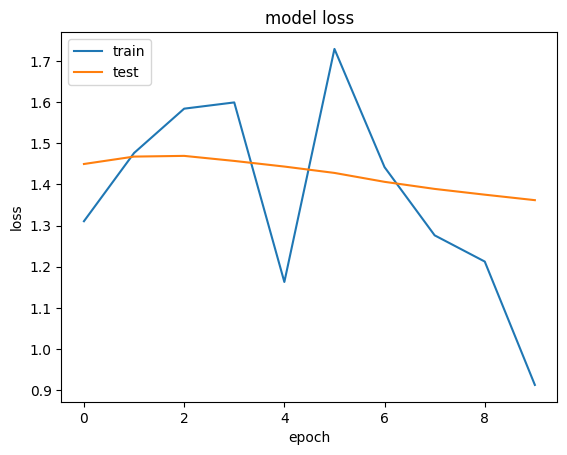

In [91]:
# Plot loss
plt.plot(model_history2.history['loss'])
plt.plot(model_history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
print(model_history2.history.keys())

train_accuracy = model_history2.history['categorical_accuracy']
val_accuracy = model_history2.history['val_categorical_accuracy']

# Print or visualize the accuracy values over epochs
print("Training Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

dict_keys(['loss', 'categorical_crossentropy', 'categorical_accuracy', 'val_loss', 'val_categorical_crossentropy', 'val_categorical_accuracy'])
Training Accuracy: [0.3333333432674408, 0.6111111044883728, 0.6388888955116272, 0.6111111044883728, 0.5, 0.5833333134651184, 0.5, 0.6666666865348816, 0.5277777910232544, 0.75]
Validation Accuracy: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')